# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

План работы: 
- подготовим данные;
- исследуем баланс классов и обучим модель без учёта дисбаланса;
- улучшим качество модели, учитывая дисбаланс классов, также обучим разные модели и найдем лучшую;
- проведем финальное тестирование.

## Подготовка данных

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/Churn.csv')

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Из полученных таблиц видим, что в датасете имеется 14 столбцов, в каждом из которых 10000 объектов, кроме столбца *Tenure* с пропущенными значениями.

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:
- Exited — факт ухода клиента

Проверим таблицу на дубликаты:

In [ ]:
data.duplicated().sum()

0

Дубликатов нет, перейдем к пропускам в столбце Tenure. Заменим пропущенные значения на медиану столбца.

In [ ]:
data['Tenure'] = data['Tenure'].fillna(value=data['Tenure'].median())

В таблице есть столбцы, а именно RowNumber, CustomerId и Surname, которые не несут ценности для обучения модели, поэтому их можно удалить.

In [ ]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Среди данных есть категориальные признаки с типом *object*, которые помешают нам при обучении моделей. Необходимо преобразовать их в численные с помощью техники прямого кодирования (One-Hot Encoding), которая подходит для всех моделей.

In [ ]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [ ]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)


После преобразования разбили исходные данные на обучающую, валидационную и тестовую выборки в размере 60%, 20% и 20% соответственно.

Для проверки напечатаем размеры полученных выборок:

In [ ]:
features_train.shape

(6000, 11)

In [ ]:
features_valid.shape

(2000, 11)

In [ ]:
features_test.shape

(2000, 11)

Так как у признаков разный масштаб, приведем их к одному масштабу с помощью стандартизации данных.

In [ ]:
numeric = ['CreditScore','Balance', 'EstimatedSalary','Tenure','Age', 'NumOfProducts']

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric]) 
features_test[numeric] = scaler.transform(features_test[numeric]) 

В данном шаге были проведены изучение файла и подготовка данных, в которую включена проверка на дубликаты, отработка пропусков, обработка типов признаков и масштабирование. Перейдем к исследованию задачи.

## Исследование задачи

В данном шаге необходимо исследовать баланс классов и обучить модель без его учета.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


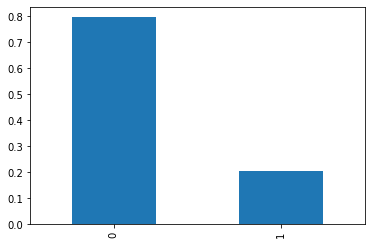

In [ ]:
class_frequency = data_ohe['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

Можем видеть, что присутствует дисбаланс классов в соотношении 80% на 20%. Обучим модели без учета дисбаланса, рассмотрим дерево решений, случайный лес и логистическую регрессию.

Начнем с дерева решений:

In [ ]:
model = DecisionTreeClassifier(random_state=12345)

In [ ]:
parameters = {'max_depth': range (1,10)}
clf = GridSearchCV(model, param_grid = parameters, scoring = 'f1', cv = 5)

train_clf = clf.fit(features_train,target_train)
predicted_valid = clf.predict(features_valid)

In [ ]:
clf.best_params_

{'max_depth': 7}

In [ ]:
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = clf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [ ]:
print('Дерево решений:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", f1)
print('auc_roc:', auc_roc)

Дерево решений:

F1 мера лучшей модели на валидационной выборке: 0.5544267053701016
auc_roc: 0.833928366715252


Рассмотрим модель случайного леса:

In [ ]:
model = RandomForestClassifier(random_state=12345) 

parameters = {'max_depth': range (1,15), 'n_estimators': range (10, 60, 10), 'min_samples_leaf': range(1,5)}
clf = GridSearchCV(model, param_grid = parameters, scoring = 'f1', cv = 5)

train_clf = clf.fit(features_train,target_train)
predicted_valid = clf.predict(features_valid)

In [ ]:
clf.best_params_

{'max_depth': 14, 'min_samples_leaf': 1, 'n_estimators': 50}

In [ ]:
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = clf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [ ]:
print('Случайный лес:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", f1)
print('auc_roc:', auc_roc)

Случайный лес:

F1 мера лучшей модели на валидационной выборке: 0.5454545454545454
auc_roc: 0.8601309271950106


Рассмотрим модель логистической регрессии:

In [ ]:
model = LogisticRegression(random_state=12345)

parameters = {'penalty':['l1', 'l2'],
     'C': [0.1,1,10,100],
     'solver':['liblinear'],
     'max_iter':[100,500]}

clf = GridSearchCV(model, param_grid = parameters, scoring = 'f1', cv = 5)

train_clf = clf.fit(features_train,target_train)
predicted_valid = clf.predict(features_valid)

In [ ]:
clf.best_params_ 

{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = clf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [ ]:
print('Логистическая регрессия:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", f1)
print('auc_roc:', auc_roc)

Логистическая регрессия:

F1 мера лучшей модели на валидационной выборке: 0.3012259194395797
auc_roc: 0.7582015599899355


У всех моделей низкие показатели f1 меры, которые свидетельствуют о низком качестве модели. Без учета дисбаланса самая высокая мера F1 у дерева решений, а мера auc-roc у случайного леса. В следующем шаге учтем дисбаланс классов техниками *Upsampling и Downsampling* и сравним модели.

## Борьба с дисбалансом

Увеличим выборку по технике *upsampling*, добавим функцию и проверим все модели:

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

In [ ]:
print(features_upsampled.shape)
print(target_upsampled.shape)

(10876, 11)
(10876,)


In [ ]:
best_model = None
best_result = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_upsampled, target_upsampled)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_result:
        best_model = model
        best_result = f1

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Дерево решений:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", best_result)
print('auc_roc:', auc_roc)
print("Depth:",depth)

Дерево решений:

F1 мера лучшей модели на валидационной выборке: 0.594059405940594
auc_roc: 0.8402380034272732
Depth: 9


In [ ]:
best_model = None
best_result = 0
for depth in range(1, 15):
    for est in range(10,60,10):
        for sample in range(1,5):
            model = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=est, min_samples_leaf=sample) 
            model.fit(features_upsampled, target_upsampled)
            predictions_valid = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions_valid)
            if f1 > best_result:
                best_model = model 
                best_result = f1

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Случайный лес:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", best_result)
print('auc_roc:', auc_roc)
print("max_depth:", depth, "n_estimators:", est, "min_samples_leaf:", sample)

Случайный лес:

F1 мера лучшей модели на валидационной выборке: 0.6398429833169774
auc_roc: 0.8697517087979084
max_depth: 14 n_estimators: 50 min_samples_leaf: 4


In [ ]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_upsampled, target_upsampled)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Логистическая регрессия:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", f1)
print('auc_roc:', auc_roc)

Логистическая регрессия:

F1 мера лучшей модели на валидационной выборке: 0.48716067498165816
auc_roc: 0.7647017661920792


Из результатов видим, что при использовании техники *upsampling* наибольшее значение меры F1 имеет модель *Случайного леса*, которая равна 0.64, и метрика auc-roc - 0.86, которая больше чем у случайной модели, но в то же время не совсем близка к 1.

Параметры модели: max_depth: 14, n_estimators: 50, min_samples_leaf: 4

Проверим также технику *downsampling*, при которой объекты частого класса становятся не частыми, то есть выборка уменьшается.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [ ]:
print(features_downsampled.shape)
print(target_downsampled.shape)

(1697, 11)
(1697,)


In [ ]:
best_model = None
best_result = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_downsampled, target_downsampled)
    predictions_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_result:
        best_model = model
        best_result = f1

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Дерево решений:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", best_result)
print('auc_roc:', auc_roc)
print("Depth:",depth)

Дерево решений:

F1 мера лучшей модели на валидационной выборке: 0.5430566330488751
auc_roc: 0.8103587917298797
Depth: 9


In [ ]:
best_model = None
best_result = 0
for depth in range(1, 15):
    for est in range(10,60,10):
        for sample in range(1,5):
            model = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=est, min_samples_leaf=sample) 
            model.fit(features_downsampled, target_downsampled)
            predictions_valid = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions_valid)
            if f1 > best_result:
                best_model = model 
                best_result = f1

probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Случайный лес:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", best_result)
print('auc_roc:', auc_roc)
print("max_depth:", depth, "n_estimators:", est, "min_samples_leaf:", sample)

Случайный лес:

F1 мера лучшей модели на валидационной выборке: 0.5053333333333333
auc_roc: 0.8242614315639651
max_depth: 14 n_estimators: 50 min_samples_leaf: 4


In [ ]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_downsampled, target_downsampled)
predictions_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Логистическая регрессия:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", f1)
print('auc_roc:', auc_roc)

Логистическая регрессия:

F1 мера лучшей модели на валидационной выборке: 0.4231387252276379
auc_roc: 0.7652690081900216


При использовании техники *downsampling* полученные результаты ниже, чем при использовании *upsampling*.

Теперь попробуем метод по взвешиванию классов, используем аргумент *class_weight* при обучении моделей и проверим результаты.

In [ ]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
parameters = {'max_depth': range (1,10)}
clf = GridSearchCV(model, param_grid = parameters, scoring = 'f1', cv = 5).fit(features_train, target_train)
predicted_valid = clf.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = clf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [ ]:
print('Дерево решений:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", f1)
print('auc_roc:', auc_roc)

Дерево решений:

F1 мера лучшей модели на валидационной выборке: 0.5933852140077821
auc_roc: 0.8190661797219174


In [ ]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced') 
parameters = {'max_depth': range (1,15), 'n_estimators': range (10, 60, 10), 'min_samples_leaf': range(1,5)}
clf = GridSearchCV(model, param_grid = parameters, scoring = 'f1', cv = 5).fit(features_train, target_train)
predicted_valid = clf.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = clf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [ ]:
clf.best_params_ 

{'max_depth': 12, 'min_samples_leaf': 4, 'n_estimators': 40}

In [ ]:
print('Случайный лес:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", f1)
print('auc_roc:', auc_roc)

Случайный лес:

F1 мера лучшей модели на валидационной выборке: 0.6462264150943395
auc_roc: 0.8702340878197808


In [ ]:
model = LogisticRegression(random_state=12345, class_weight='balanced')

parameters = {'penalty':['l1', 'l2'],
     'C': [0.1,1,10,100],
     'solver':['liblinear'],
     'max_iter':[100,500]}

clf = GridSearchCV(model, param_grid = parameters, scoring = 'f1', cv = 5)

train_clf = clf.fit(features_train, target_train)
predicted_valid = clf.predict(features_valid)

f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = clf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [ ]:
print('Логистическая регрессия:')
print('')
print("F1 мера лучшей модели на валидационной выборке:", f1)
print('auc_roc:', auc_roc)

Логистическая регрессия:

F1 мера лучшей модели на валидационной выборке: 0.5092436974789916
auc_roc: 0.7654342676697371


При методе по взвешиванию классов лучший результат F1 у модели Случайного леса - 0.65, при значении auc-roc 0.87, что является лучшим результатом среди всех техник и моделей. 

- F1 мера лучшей модели на валидационной выборке: 0.6462264150943395
- auc_roc: 0.8702340878197808

Проведем финальное тестирование модели.

## Тестирование модели

In [ ]:
model = RandomForestClassifier(random_state=12345, max_depth = 12, min_samples_leaf = 4, n_estimators = 40, class_weight='balanced') 

model.fit(features_train, target_train)
predicted_test= model.predict(features_test)

f1 = f1_score(target_test, predicted_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

In [ ]:
print("F1 мера:", f1)
print("Auc-roc мера:", auc_roc)

F1 мера: 0.608805031446541
Auc-roc мера: 0.845132637863425


При проверки модели на тестовой выборке получили результат F1 меры равный 0.61 и Auc-roc меры - 0.85.

<Figure size 432x288 with 0 Axes>

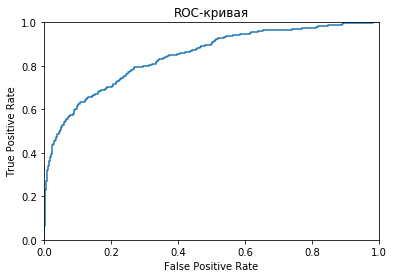

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Общий вывод

В данном проекте были обучены и изучены модели дерево решений, случайный лес и логистическая регрессия без учета и с учетом дисбаланса классов. 

Дисбаланс классов был исправлен с помощью нескольких способов: техники upsampling и downsampling, а также метод по взвешиванию классов. Все модели были изучены при всех техниках, и самая лучшая модель была Случайный лес при методе по взвешиванию классов.

Параметры модели: 'max_depth': 12, 'min_samples_leaf': 4, 'n_estimators': 40.

Полученные результаты:
- на валидационной выборке: f1 мера - 0.646;
- на тестовой выборке: f1 мера - 0.609.